In [ ]:
!pip install pyarrow

In [1]:
import numpy as np
import pandas as pd
import pyarrow
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"PyArrow: {pyarrow.__version__}")

NumPy: 1.26.4
Pandas: 2.0.3
PyArrow: 12.0.1


In [2]:
# to store the model
import pickle
# to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    # transfer datetime
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    # Calculate duration
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [11]:
# Question 1. Downloading the data
print(f"Number of columns: {len(df_train.columns)-1}")

Number of columns: 19


In [13]:
# Question 2. Computing duration 
std_dev = df_train['duration'].std()
print(f"The standard deviation is {std_dev:.2f} minutes")

The standard deviation is 42.59 minutes


In [17]:
# Question 3. Dropping outliers
mask = (df_train['duration'] >= 1) & (df_train['duration'] <= 60)
df_org = df_train.copy()
df_train = df_train[mask].copy()
print(f"Original row count: {len(df_org)}")
print(f"Filtered row count: {len(df_train)}")
fraction = len(df_train) / len(df_org)
print(f"fraction left is {fraction:.2%}")

Original row count: 3066766
Filtered row count: 3009173
fraction left is 98.12%


In [18]:
# Question 4. One-hot encoding
categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']
train_dicts = df_train[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print(f"Dimensionality (Number of columns): {X_train.shape[1]}")

Dimensionality (Number of columns): 515


In [28]:
# Question 5. Training a model. RMSE on train
target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

print(f"RMSE on train: {root_mean_squared_error(y_train, y_pred):.3f}")

RMSE on train: 7.649


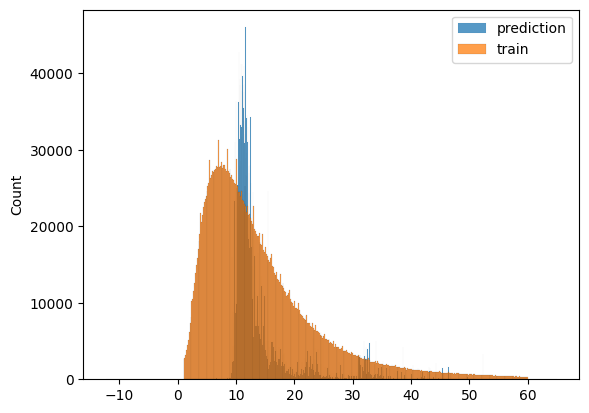

In [29]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='train')

plt.legend()

In [27]:
# Question 6. Evaluating the model. RMSE on validation
mask = (df_val.duration >= 1) & (df_val.duration <= 60)
df_val = df_val[mask].copy()
categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_val = df_val[target].values

y_pred = lr.predict(X_val)
print(f"RMSE on val: {root_mean_squared_error(y_val, y_pred):.2f}")

RMSE on val: 7.81


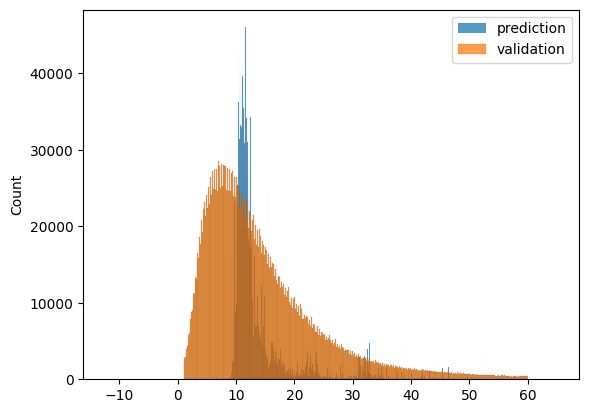

In [32]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='validation')

plt.legend()